# Upstream regulation network reconstruction, with synonym expansion, and network summarization (based on standard names)

The following code defines the main parameter and data considered as input: 
- SPARQL_ENDPOINT : the main PathwayCommons (PC) SPARQL endpoint 
- CHUNKS_SIZE : the number of genes to be processed within each PC query
- MAX_DEPTH : the maximum depth of exploration, can be null to explore the full regulation graph
- DATA_SOURCES : used to limit the data source to be explored. Must be a list of values from : bind, biogrid, corum, ctd, dip, drugbank, hprd, humancyc, inoh, intact, kegg, mirtarbase, netpath, panther, pid, psp, reactome, reconx, smpdb, wp, intact_complex, msigdb. 

In [1]:
from typing import List, Any

from IPython.display import display, Markdown, Latex
from rdflib import Graph, RDF, RDFS, Namespace
from SPARQLWrapper import SPARQLWrapper, JSON
from string import Template

import networkx as nx
import matplotlib.pyplot as plt
#from nxpd import draw

import requests
import json
import io
import time
import csv

INPUT_GENES = ['JUN/FOS', 'SCN5A']

SPARQL_ENDPOINT = "http://rdf.pathwaycommons.org/sparql"  # type: str
CHUNKS_SIZE = 20  # type: int
MAX_DEPTH = 2 # type: int
SKIP_SMALL_MOLECULES = True # type: Boolean
DATA_SOURCES = ['pid', 'humancyc', 'panther', 'msigdb']
#DATA_SOURCES = []  # type: List[str]

HAS_MAX_DEPTH = False
try:
  MAX_DEPTH
except NameError:
  HAS_MAX_DEPTH = False
else:
  HAS_MAX_DEPTH = True

HAS_DATA_SOURCES = False
try:
  DATA_SOURCES
except NameError:
  HAS_DATA_SOURCES = False
else:
  HAS_DATA_SOURCES = True

In [2]:
def init_gene_synonyms_cache():
    cache = []
    with open('Homo_sapiens.gene_info', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
        for row in reader:
            entry = {'key':row[2], 'synonym':row[4].split('|')}
            cache.append(entry)
    return cache

def init_gene_synonyms_cache_v2():
    index_syn = {}
    index_std = {}
    with open('Homo_sapiens.gene_info', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
        for row in reader:
            index_std[row[2]] = row[4].split('|')
            
            index_syn[row[2]] = row[2]
            for syn in row[4].split('|'):
                index_syn[syn] = row[2]
    return index_std, index_syn

cache = init_gene_synonyms_cache()

print('--- Memory foot print cache v1 ---')
s = 0
for e in cache:
    s += 1 + len(e['synonym'])
print('Cache size : '+str(s))

print('--- Memory foot print cache v2 ---')
index_std, index_syn = init_gene_synonyms_cache_v2()
print('index_syn size : ' + str(len(index_syn.keys()) * 2))
s = 0
for key, value in index_std.items():
    s += 1 + len(value)
print('index_std size : ' + str(s))

--- Memory foot print cache v1 ---
Cache size : 161857
--- Memory foot print cache v2 ---
index_syn size : 244398
index_std size : 161611


In [3]:
def are_synonyms(n, m, syn_cache):
    for entry in syn_cache:
        all_possible_names = entry['synonym'] + [entry['key']]
        if (n in all_possible_names) and (m in all_possible_names):
            return True
    return False

def get_synonyms(n, syn_cache):
    all_possible_names = []
    for entry in syn_cache:
        all_possible_names = entry['synonym'] + [entry['key']]
        if (n in all_possible_names):
            all_possible_names.remove(n)
            return all_possible_names
    return all_possible_names

def get_std_name(n, syn_cache):
    for entry in syn_cache:
        all_possible_names = entry['synonym'] + [entry['key']]
        if (n in all_possible_names):
            return entry['key']
        
start = time.time()
print('ABG has for synonyms: ' + str(get_synonyms('ABG', cache)))
print('ABG has for standard name: ' + str(get_std_name('ABG', cache)))
elapsed = time.time() - start
print('Time = ' + str(elapsed))

ABG has for synonyms: ['A1B', 'GAB', 'HYST2477', 'A1BG']
ABG has for standard name: A1BG
Time = 0.0005500316619873047


In [4]:
def fast_get_std_name(n, index_syn):
    return index_syn[n]

def fast_get_synonyms(n, index_std, index_syn):
    std = index_syn[n]
    synonyms = index_std[std]
    all_names = []
    all_names = [std] + synonyms
    all_names.remove(n) 
    return all_names

def fast_are_synonyms(n, m, index_syn):
    try:
        index_syn[n]
    except:
        return False
    try:
        index_syn[m]
    except:
        return False
    return (index_syn[n] == index_syn[m])

start = time.time()
print('ABG has for synonyms: ' + str(fast_get_synonyms('ABG', index_std=index_std, index_syn=index_syn)))
print('ABG has for standard name: ' + str(fast_get_std_name('ABG', index_syn=index_syn)))
elapsed = time.time() - start
print('Time = ' + str(elapsed))

ABG has for synonyms: ['A1BG', 'A1B', 'GAB', 'HYST2477']
ABG has for standard name: A1BG
Time = 0.0003669261932373047


# 1. Pathway Commons template SPARQL query
The query will be post-processed to integrate filters on gene names `$filter_Chunks`, for skipping small molecules `$filter_SkipSmallMollecules`, and considering only a subset of data sources `$filter_DataSources`. 

In [5]:
tpl_select_reg_query = """
PREFIX bp: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT ?controllerName ?controlType ?controlledName ?ds WHERE {
    $filter_Chunks
    $filter_SkipSmallMollecules
    $filter_DataSources
    
    ?participant bp:displayName ?controlledName ;
        rdf:type ?controlledType .
    ?controller bp:displayName ?controllerName ;
        rdf:type ?controllerType . 
    
    ?controlled bp:participant ?participant .

    ?tempReac a bp:TemplateReactionRegulation ; 
        bp:controlled ?controlled ; 
        bp:controller ?controller ; 
        bp:controlType ?controlType ; 
        bp:dataSource ?source . 
} 
"""

The query is based on the BioPax ontology. It aims at matching a graph pattern on the full Pathway Commons knowledge base. The following diagram shows variable graph nodes (dashed circles), fixed nodes (rectangle), and what we search for in red. 

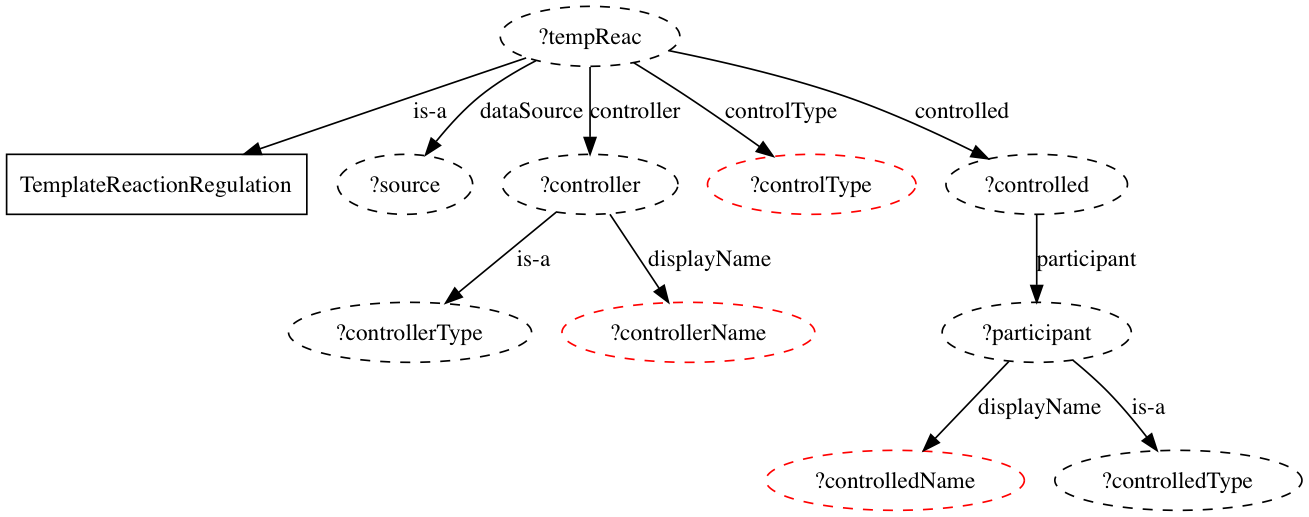

In [6]:
from nxpd import draw
bgp = nx.DiGraph()
bgp.graph['dpi'] = 120

bgp.add_node("?controllerName", color="red")
bgp.add_node("?controlType", color="red")
bgp.add_node("?controlledName", color="red")

bgp.add_edge("?participant", "?controlledName", label="displayName")
bgp.add_edge("?participant", "?controlledType", label="is-a")
bgp.add_edge("?controller", "?controllerName", label="displayName")
bgp.add_edge("?controller", "?controllerType", label="is-a")
bgp.add_edge("?controlled", "?participant", label="participant")
bgp.add_edge("?tempReac", "TemplateReactionRegulation", label="is-a")
bgp.add_edge("?tempReac", "?controlled", label="controlled")
bgp.add_edge("?tempReac", "?controller", label="controller")
bgp.add_edge("?tempReac", "?controlType", label="controlType")
bgp.add_edge("?tempReac", "?source", label="dataSource")
for e in bgp.edges():
    for i in range(0,2):
        if "?" in e[i]:
            bgp.add_node(e[i], style='dashed')
        else: 
            bgp.add_node(e[i], shape='rectangle')
    
draw(bgp, show='ipynb')

### Splitting a list of genes based on `CHUNKS_SIZE`

In [7]:
def gen_chunks(list_of_genes):
    """
    """
    chunks_list = []
    chunk = []
    cpt = 0
    for gene in list_of_genes:
        chunk.append(gene)
        cpt += 1
        if ((cpt % CHUNKS_SIZE) == 0):
            chunks_list.append(chunk)
            chunk = []
    if (len(chunk) > 0):
        chunks_list.append(chunk)
    return chunks_list

### Generation of a SPARQL Filter clause to restrict data sources
Produces something like
```
FILTER (?source IN (<http://pathwaycommons.org/pc2/pid>, <http://pathwaycommons.org/pc2/humancyc>))
```

In [8]:
def gen_data_source_filter(data_sources):
    """
    generates a SPARQL Filter clause aimed at 
    limiting the possible values of a ?source vairable
    """
    filter_clause = ''
    if len(data_sources) > 0 : 
        filter_clause = 'FILTER (?source IN ('
        for ds in data_sources :
            dsUri = '<http://pathwaycommons.org/pc2/' + ds.lower() + '>'
            filter_clause = filter_clause + dsUri + ', '
        k = filter_clause.rfind(", ")
        filter_clause = filter_clause[:k]
        filter_clause = filter_clause + ')) .'
    return filter_clause

### Generation of a SPARQL Filter clause to restrict gene/protein/etc. names
Produces something like
```
FILTER (
    ((?controlledName = "JUN"^^xsd:string) && (?controllerName != "JUN"^^xsd:string))
    || ((?controlledName = "FOS"^^xsd:string) && (?controllerName != "FOS"^^xsd:string))
```

In [9]:
def gen_chunks_filter(chunks):
    """
    """
    filter_clause = ''
    if len(chunks) > 0 : 
        filter_clause = 'FILTER ( \n'
        for g in chunks :
            filter_clause += '((?controlledName = "' + g + '"^^xsd:string) && (?controllerName != "' + g + '"^^xsd:string)) \n'
            filter_clause +=' || '
        k = filter_clause.rfind(" || ")
        filter_clause = filter_clause[:k]
        filter_clause += ' ) .'
    return filter_clause

### Generation of a SPARQL Filter clause to exclude small molecules
Produces something like
```
FILTER( str(?controllerType) != "http://www.biopax.org/release/biopax-level3.owl#SmallMolecule")
```

In [10]:
def gen_small_mol_filter(skip_small_molecules = True):
    if skip_small_molecules:
        return 'FILTER( str(?controllerType) != "http://www.biopax.org/release/biopax-level3.owl#SmallMolecule")  .'
    else:
        return ''

# 2. Upstream regulation algorithm
Recursive exploration with two stopping criteria: 
- nothing new to explore
- the maximum exploration depth is reached

In [11]:
def upstream_regulation(to_be_explored, already_explored, sif_network, depth, explored_reg):
    """
    """
    
    """ 1st stopping criteria """
    if len(to_be_explored) == 0:
        print("Exploring done")
        return sif_network
    
    """ 2nd stopping criteria """
    if (HAS_MAX_DEPTH and (depth >= MAX_DEPTH)):
        print("Exploring alted due to maximum depth")
        return sif_network
    
    print()
    print('exploration depth ' + str(depth))
    print('to be explored ' + str(to_be_explored))
    
    """ Decomposing protein complexes """
    new_to_be_explored = []
    for name in to_be_explored:
        splits = name.split('/')
        if len(splits) > 1 : 
            print(name + ' decomposed into ' + str(splits))
            new_to_be_explored.extend(splits)
            for s in splits:
                sif_network.append({"source":s, "relation":"PART_OF", "target":name})
    
    for new in new_to_be_explored:
        if new not in to_be_explored:
                to_be_explored.append(new)
    print('to be explored after complex decomposition ' + str(to_be_explored))
    
    """ Expanding the list with synonyms """
    new_to_be_explored = []
    for name in to_be_explored:
        synonyms = get_synonyms(name, cache)
        for s in synonyms:
            if s not in "-":
                new_to_be_explored.append(s)
    if len(new_to_be_explored) > 0:
        print('new synonmys to be explored:' + str(new_to_be_explored))
    
    for new in new_to_be_explored:
        if new not in to_be_explored:
                to_be_explored.append(new)
    
    """ Grouping genes into chunks to be processed remotely by block """
    chunks = gen_chunks(to_be_explored)
    to_be_explored = []
    
    for regulators in chunks :
        print('exploring ' + str(regulators))
        query = Template(tpl_select_reg_query)
        
        fds = gen_data_source_filter(DATA_SOURCES)
        fchunks = gen_chunks_filter(regulators)
        ssm = gen_small_mol_filter(SKIP_SMALL_MOLECULES)
        
        q = query.substitute(filter_DataSources = fds,
                    filter_SkipSmallMollecules = ssm, 
                    filter_Chunks = fchunks)
        
        print("=====================")
        print(q)
        print("=====================")
        
        sparql = SPARQLWrapper(SPARQL_ENDPOINT)
        sparql.setQuery(q)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        
        already_explored.extend(regulators)
        #print('already explored ' + str(already_explored))
        
        for result in results["results"]["bindings"]:
            source, reg_type, target = result["controllerName"]["value"], result["controlType"]["value"], result["controlledName"]["value"]
            sif_network.append({"source":source, "relation":reg_type, "target":target})
            #print(source + ' --- ' + reg_type + ' --> ' + target)
            
            if source not in already_explored:
                if source not in to_be_explored:
                    to_be_explored.append(source)
                    explored_reg += 1
                    #print('Adding ' + source + ', in to_be_explored')
            #else:
                #print('skipping ' + source + ', already_explored')
        
        print()
        print('Explored ' + str(explored_reg)+ ' regulators')
        
    depth += 1
    upstream_regulation(to_be_explored, already_explored, sif_network, depth, explored_reg)
    
    return sif_network

# 3. RUNNING the algorithm
based on the `INPUT_GENES` list. 

In [12]:
start_time = time.time()

reconstructed_network = upstream_regulation(["JUN/FOS", "SCN5A"], [], [], depth=0, explored_reg=0)

elapsed_time = round((time.time() - start_time), 2)
print("--- Upstream regulation network in %s seconds ---" % elapsed_time)

G = nx.DiGraph()
for e in reconstructed_network:
#    print(e['source'] + ' --- ' + e['regulation'] + ' --> ' + e['target'])
    G.add_edge(e['source'], e['target'], 
               color = 'g' if (e['relation'] in 'ACTIVATION') else 'r',
               label=e['relation'])

print('Number of nodes = ' + str(len(G.nodes())))
print('Number of edges = ' + str(len(G.edges())))


exploration depth 0
to be explored ['JUN/FOS', 'SCN5A']
JUN/FOS decomposed into ['JUN', 'FOS']
to be explored after complex decomposition ['JUN/FOS', 'SCN5A', 'JUN', 'FOS']
new synonmys to be explored:['16S rRNA', 'CDCD2', 'CMD1E', 'CMPD2', 'HB1', 'HB2', 'HBBD', 'HH1', 'ICCD', 'IVF', 'LQT3', 'Nav1.5', 'PFHB1', 'SSS1', 'VF1', 'AP-1', 'AP1', 'c-Jun', 'p39', 'AP-1', 'C-FOS', 'p55']
exploring ['JUN/FOS', 'SCN5A', 'JUN', 'FOS', '16S rRNA', 'CDCD2', 'CMD1E', 'CMPD2', 'HB1', 'HB2', 'HBBD', 'HH1', 'ICCD', 'IVF', 'LQT3', 'Nav1.5', 'PFHB1', 'SSS1', 'VF1', 'AP-1']

PREFIX bp: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT ?controllerName ?controlType ?controlledName ?ds WHERE {
    FILTER ( 
((?controlledName = "JUN/FOS"^^xsd:string) && (?controllerName != "JUN/FOS"^^xsd:string)) 
 || ((?controlledName = "SCN5A"^^xsd:string) && (?controllerName != "SCN5A"^^xsd:string)) 


Explored 165 regulators
exploring ['ATF2', 'REPIN1', 'ZEB1', 'GATA1', 'LEF1', 'ELK1/SRF', 'Calcineurin A alpha-beta B1', 'AP1', 'SMAD3/SMAD4/JUN/FOS', 'RHOA/GTP', 'TCR/CD3/MHC II/CD4', 'IL12/IL12R/TYK2/JAK2', 'JDP2', 'Jnk1', 'ATF2/c-Jun', 'ELK1', 'JNK1-2-active', 'ATF1', 'NRF1', 'PAX2']

PREFIX bp: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT ?controllerName ?controlType ?controlledName ?ds WHERE {
    FILTER ( 
((?controlledName = "ATF2"^^xsd:string) && (?controllerName != "ATF2"^^xsd:string)) 
 || ((?controlledName = "REPIN1"^^xsd:string) && (?controllerName != "REPIN1"^^xsd:string)) 
 || ((?controlledName = "ZEB1"^^xsd:string) && (?controllerName != "ZEB1"^^xsd:string)) 
 || ((?controlledName = "GATA1"^^xsd:string) && (?controllerName != "GATA1"^^xsd:string)) 
 || ((?controlledName = "LEF1"^^xsd:string) && (?controllerName != "LEF1"^^xsd:string)) 
 || ((


Explored 245 regulators
exploring ['c-Jun', 'PUR1', 'Pur-1', 'SAF-1', 'SAF-2', 'SAF-3', 'ZF87', 'ZNF801', 'Zif87', 'BRN2', 'N-Oct3', 'OCT7', 'OTF-7', 'OTF7', 'POUF3', 'brn-2', 'oct-7', 'CREB', 'CREB-1', 'C/EBP-alpha']

PREFIX bp: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT ?controllerName ?controlType ?controlledName ?ds WHERE {
    FILTER ( 
((?controlledName = "c-Jun"^^xsd:string) && (?controllerName != "c-Jun"^^xsd:string)) 
 || ((?controlledName = "PUR1"^^xsd:string) && (?controllerName != "PUR1"^^xsd:string)) 
 || ((?controlledName = "Pur-1"^^xsd:string) && (?controllerName != "Pur-1"^^xsd:string)) 
 || ((?controlledName = "SAF-1"^^xsd:string) && (?controllerName != "SAF-1"^^xsd:string)) 
 || ((?controlledName = "SAF-2"^^xsd:string) && (?controllerName != "SAF-2"^^xsd:string)) 
 || ((?controlledName = "SAF-3"^^xsd:string) && (?controllerName != "SAF-3


Explored 247 regulators
exploring ['KAT3B', 'RSTS2', 'EP300', 'CRE-BP1', 'CREB-2', 'CREB2', 'HB16', 'TREB7', 'AP4', 'RIP60', 'ZNF464', 'Zfp464', 'AREB6', 'BZP', 'DELTAEF1', 'FECD6', 'NIL2A', 'PPCD3', 'TCF8', 'ZFHEP']

PREFIX bp: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT ?controllerName ?controlType ?controlledName ?ds WHERE {
    FILTER ( 
((?controlledName = "KAT3B"^^xsd:string) && (?controllerName != "KAT3B"^^xsd:string)) 
 || ((?controlledName = "RSTS2"^^xsd:string) && (?controllerName != "RSTS2"^^xsd:string)) 
 || ((?controlledName = "EP300"^^xsd:string) && (?controllerName != "EP300"^^xsd:string)) 
 || ((?controlledName = "CRE-BP1"^^xsd:string) && (?controllerName != "CRE-BP1"^^xsd:string)) 
 || ((?controlledName = "CREB-2"^^xsd:string) && (?controllerName != "CREB-2"^^xsd:string)) 
 || ((?controlledName = "CREB2"^^xsd:string) && (?controllerName !=


Explored 248 regulators
exploring ['HSF 2', 'HSTF 2', 'STAT5', 'KPD', 'MODY9', 'B1G1', 'CD66f', 'DHFRP2', 'FL-NCA-1/2', 'PBG1', 'PS-beta-C/D', 'PS-beta-G-1', 'PSBG-1', 'PSBG1', 'PSG95', 'PSGGA', 'PSGIIA', 'PSG1', 'MGF', 'AT591']

PREFIX bp: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT ?controllerName ?controlType ?controlledName ?ds WHERE {
    FILTER ( 
((?controlledName = "HSF 2"^^xsd:string) && (?controllerName != "HSF 2"^^xsd:string)) 
 || ((?controlledName = "HSTF 2"^^xsd:string) && (?controllerName != "HSTF 2"^^xsd:string)) 
 || ((?controlledName = "STAT5"^^xsd:string) && (?controllerName != "STAT5"^^xsd:string)) 
 || ((?controlledName = "KPD"^^xsd:string) && (?controllerName != "KPD"^^xsd:string)) 
 || ((?controlledName = "MODY9"^^xsd:string) && (?controllerName != "MODY9"^^xsd:string)) 
 || ((?controlledName = "B1G1"^^xsd:string) && (?controllerName


Explored 249 regulators
exploring ['TFAP2', 'OCT1', 'OTF1', 'oct-1B', 'HNF-1A', 'HNF1', 'HNF4A', 'IDDM20', 'LFB1', 'MODY3', 'TCF-1', 'TCF1', 'C/EBP-delta', 'CELF', 'CRP3', 'NF-IL6-beta', 'IMD39', 'IRF-7', 'IRF-7H', 'IRF7A']

PREFIX bp: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT ?controllerName ?controlType ?controlledName ?ds WHERE {
    FILTER ( 
((?controlledName = "TFAP2"^^xsd:string) && (?controllerName != "TFAP2"^^xsd:string)) 
 || ((?controlledName = "OCT1"^^xsd:string) && (?controllerName != "OCT1"^^xsd:string)) 
 || ((?controlledName = "OTF1"^^xsd:string) && (?controllerName != "OTF1"^^xsd:string)) 
 || ((?controlledName = "oct-1B"^^xsd:string) && (?controllerName != "oct-1B"^^xsd:string)) 
 || ((?controlledName = "HNF-1A"^^xsd:string) && (?controllerName != "HNF-1A"^^xsd:string)) 
 || ((?controlledName = "HNF1"^^xsd:string) && (?controllerName !=


Explored 250 regulators
Exploring alted due to maximum depth
--- Upstream regulation network in 44.49 seconds ---
Number of nodes = 246
Number of edges = 897


In [13]:
def read_input_genes(filename):
    res = []
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for row in reader:
            res.append(''.join(row))
    return res

input_genes = read_input_genes('/Users/gaignard-a/Documents/Dev/BRAvo/nathalie-TF.csv')

In [14]:
def write_to_SIF(graph, filename):
    with open(filename, 'w', newline='') as csvfile:
        sif_writer = csv.writer(csvfile, delimiter='\t')
        for e in G.edges(data='label'):
            sif_writer.writerow([e[0], e[2], e[1]])
    print('SIF network written to ' + filename)

write_to_SIF(G, 'out.sif')


SIF network written to out.sif


In [15]:
import operator
centrality = nx.degree_centrality(G)
#centrality = nx.closeness_centrality(G)
#centrality = nx.betweenness_centrality(G)
sorted_centrality = reversed(sorted(centrality.items(), key=operator.itemgetter(1)))
sorted_centrality = list(sorted_centrality)
cpt = 0
md = """
| Gene | Degree Centrality |
|------|------|
"""
for g in sorted_centrality:
    md += "| " + g[0] + " | " + str(g[1]) + " | \n"
    cpt += 1
    if cpt > 9:
        break
#print(md)
display(Markdown(md))


| Gene | Degree Centrality |
|------|------|
| POU2F1 | 0.22448979591836737 | 
| EGR2 | 0.2 | 
| MAZ | 0.1836734693877551 | 
| FOS | 0.1836734693877551 | 
| PAX2 | 0.17551020408163268 | 
| EGR3 | 0.163265306122449 | 
| HNF1A | 0.15918367346938778 | 
| LEF1 | 0.1510204081632653 | 
| ESRRA | 0.1510204081632653 | 
| SP1 | 0.1469387755102041 | 


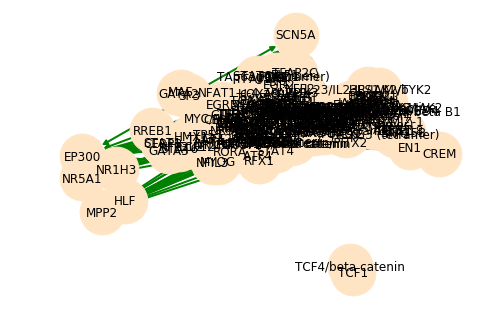

In [16]:
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]

nx.draw_spring(G, 
               with_labels=True, 
               edge_color = colors,
               node_color = 'bisque',
               font_weight='light', 
               node_size = 2000, 
               width = 2)
plt.show()

# 4. Synonym-based network simplification

In [17]:
def fast_reg_network_syn_simp(graph, index_syn):
    H = graph.copy()
    cpt = 0
    nodes_size = len(H.nodes())
    for n in H.nodes():    
        #print('for each ' + str(n))
        for m in H.nodes():
            if n not in m:
                #print('\tfor each ' + str(m))
                if (fast_are_synonyms(n,m, index_syn=index_syn)):
                    key = index_syn[n]
                    if n not in key:
                        #print('\t\t' + str(n) + ' is synonym with ' + str(m))
                        print('\t\t' + 'merging node ' + str(n) + ' into node ' + str(key))
                        try:
                            H = nx.contracted_nodes(H, key, n)
                        except:
                            continue
                    if m not in key:
                        print('\t\t' + 'merging node ' + str(m) + ' into node ' + str(key))
                        try:
                            H = nx.contracted_nodes(H, key, m)
                        except:
                            continue
    return H

In [18]:
start_time = time.time()
G_prime = fast_reg_network_syn_simp(G, index_syn)
elapsed_time = round((time.time() - start_time), 2)
print("--- Network simplification in %s seconds ---" % elapsed_time)

write_to_SIF(G_prime, 'out_second.sif')
print('Nodes after simplification = ' + str(len(G_prime.nodes())))
print('Edges after simplification = ' + str(len(G_prime.edges())))

		merging node AP1 into node JUN
		merging node AP1 into node JUN
		merging node TCF1 into node HNF1A
		merging node HNF4A into node HNF1A
		merging node TCF1 into node HNF1A
		merging node HNF4A into node HNF1A
		merging node p300 into node EP300
		merging node c-Jun into node JUN
		merging node p300 into node EP300
		merging node ATF2 into node GDNF
		merging node ATF1 into node GDNF
		merging node ATF1 into node GDNF
		merging node ICER into node CREM
		merging node c-Jun into node JUN
		merging node ICER into node CREM
		merging node FOXM1C into node FOXM1
--- Network simplification in 0.11 seconds ---
SIF network written to out_second.sif
Nodes after simplification = 238
Edges after simplification = 889


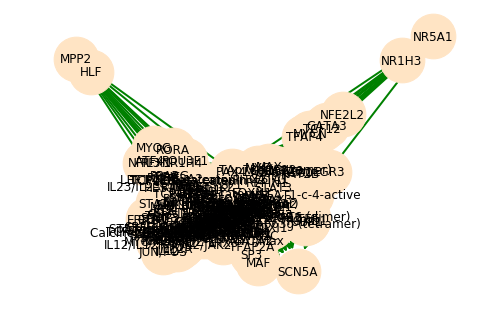

In [19]:
edges = G_prime.edges()
colors = [G_prime[u][v]['color'] for u,v in edges]

nx.draw_spring(G_prime, 
               with_labels=True, 
               edge_color = colors,
               node_color = 'bisque',
               font_weight='light', 
               node_size = 2000, 
               width = 2)
plt.show()

---
--- 
# Validating the network summarization on a simple example
In the graph, edges represent either `alias` or `regulation` links. 

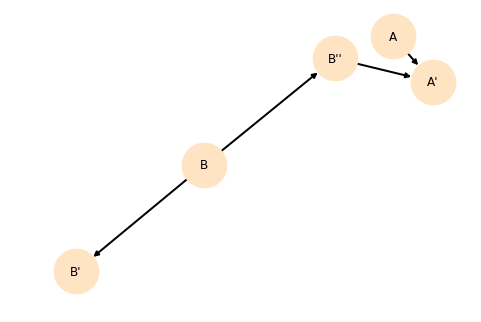

In [20]:
G2 = nx.DiGraph()
G2.add_edges_from([("B", "B'"), ("B", "B''"), ("A", "A'")], label='blue')
G2.add_edges_from([("B''", "A'")], label='red')

nx.draw_spring(G2, 
               with_labels=True, 
               node_color = 'bisque',
               font_weight='light', 
               node_size = 2000, 
               width = 2)
plt.show()

		merging node A' into node A
		merging node B' into node B
		merging node B'' into node B


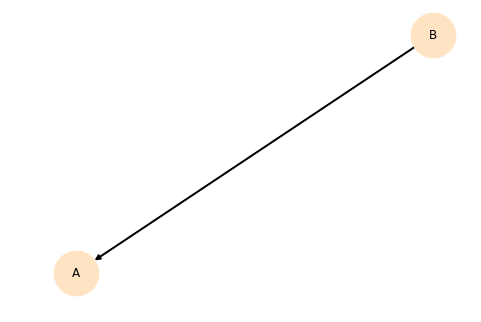

In [21]:
""" The two indexes """
i_syn = {"B'":"B", "B''":"B", 'B':'B', "A'":"A", 'A':'A'}
i_std = {"A":["A'"], "B":["B'","B''"]}

G2_prime = fast_reg_network_syn_simp(G2, i_syn)

nx.draw_spring(G2_prime, 
               with_labels=True, 
               node_color = 'bisque',
               font_weight='light', 
               node_size = 2000, 
               width = 2)
plt.show()